<h1 style="text-align: center;">
    Numerical Methods : <br>
    Rate equations or MC approaches for modelling growth <br>
    - Task 3 Report -
</h1>
<p style="text-align: center;">
Léo BECHET, M2 CompuPhys 2024-2025
</p>

# Task 3

We modify the simulation to allow deposition of a new type of monomer called type $B$.

To compute the composition of islands, we suppose that every island has approximately the same composition. As such, we will compute the amount of aggregated number of $A$ and $B$ monomers in the whole simulation.

We will stop simulations after a $20%$ fill rate, as it is the limit of our single layer growth approximation. We will then compute the islands composition as described above. A sweep is performed on $N_{dif}(B)$, from $10$ to $100$ in increments of $10$.

In [43]:
# from task2and3 import Simulation, Monomer ; _IS_PARALLEL = False# Without numba
from task2_parallel import Simulation ; _IS_PARALLEL = True# With numba


from matplotlib.colors import ListedColormap
import os
import time
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# from task2and3 import Simulation, Monomer ; _IS_PARALLEL = False# Without numba
from task2_parallel import Simulation ; _IS_PARALLEL = True# With numba





from matplotlib.colors import ListedColormap
import os
import time
import numpy as np
import matplotlib.pyplot as plt

def RunForNdifs(Ndif_A, Ndif_B, steps=40000, size=(100,100), coverage_limit=0.2):
    island_cellEvo = []
    island_numEvo = []
    monomer_numEvo = []

    # size = (100, 100)
    sim = Simulation(size, 0.5)

    # steps = 40000
    # Ndif_A = 50
    # coverage_limit = 0.2 # stop limiter


    sim_cells = size[0]*size[1]
    i=0
    while True:
        i+=1
        # deposit a monomer every n steps
        if i%Ndif_A == 0:
            sim.Deposit("A")

        if i%Ndif_B == 0:
            sim.Deposit("B")

        sim.Step() # step

        # Compute average number of cells per island
        isl, cells = sim.NumIslands()
        island_numEvo.append(isl)
        monomer_numEvo.append(sim.NumMonomers())


        try:
            island_cellEvo.append( sum(cells)/len(cells) )
        except ZeroDivisionError:
            island_cellEvo.append( 0 )

        # print("==========================================================")
        fill_ratio = sum(cells)/sim_cells # < Replaced below when not using parallel as the DFS implementation is bugged.
        # =========== DEBUG ARRAY FILL RATIO =================
        if not _IS_PARALLEL:
            new_array = np.array([[1 if isinstance(cell, Monomer) else 0 for cell in row] for row in sim.grid])
            fill_ratio = np.sum(new_array.flatten())/sim_cells


        # ====================================================

        if i%1000 == 0:os.system("clear");print(f' {Ndif_B}\tSIM {i}\t{fill_ratio*100}%')

        #Stop condition due to coverage limit, here we take aggregated coverage
        if fill_ratio >= coverage_limit:
            print('Reached 20% fill')
            break


    # Compute island composition

    new_array = np.zeros(sim.grid.shape, dtype=int)
    new_array[sim.grid == 0] = 0
    new_array[sim.grid == 11] = 1 # Aggregated of type A

    A_quantity = np.sum(new_array.flatten()) # amount of aggregated A

    # Reset array
    new_array = np.zeros(sim.grid.shape, dtype=int)
    new_array[sim.grid == 0] = 0
    new_array[sim.grid == 12] = 1 # Aggregated of type B

    B_quantity = np.sum(new_array.flatten()) # amount of aggregated B

    sum_agg = A_quantity + B_quantity

    return A_quantity/sum_agg, B_quantity/sum_agg # return percentages


In [ ]:
# Runs the sweep
Ndif_A = 50

start, points, step = 10, 10, 10

x = [i*step+start for i in range(points)]
y_A = []
y_B = []
for Ndif_B in x:
    A,B = RunForNdifs(Ndif_A, Ndif_B)
    y_A.append(A)
    y_B.append(B)

[-2.81001069e+03 -5.63758221e+01  9.94858482e-01  5.03929896e+01] [-2.79586926e+03 -5.60921119e+01  5.14152708e-03  5.03929880e+01]


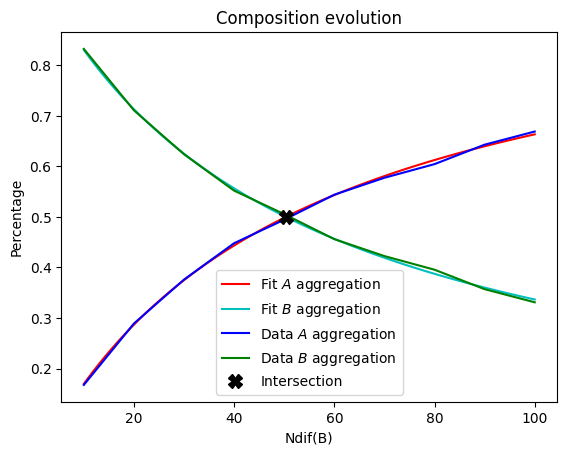

Intersection point at x = 50.33126551748839


In [42]:
from scipy.optimize import curve_fit, fsolve
import matplotlib.pyplot as plt

# Define an inverse function with parameters
def func_A(x, A, B, C, D):
    return -A / (B * (x+D)) + C

def func_B(x, A, B, C, D):
    return A / (B * (x+D)) + C

# Fit y_A
popt_A, pcov_A = curve_fit(func_A, x, y_A, maxfev=100000)
A_A, B_A, C_A, D_A = popt_A  # Extract fitted parameters for y_A

# Fit y_B
popt_B, pcov_B = curve_fit(func_B, x, y_B, maxfev=100000)
A_B, B_B, C_B, D_B = popt_B  # Extract fitted parameters for y_B

print(popt_A, popt_B)

# Define the function representing the difference between func_A and func_B
def diff(x):
    return func_A(x, *popt_A) - func_B(x, *popt_B)

# Use fsolve to find the intersection point
x_intersect = fsolve(diff, x0=0)  # Provide an initial guess for x

# Plot the fitted functions
x_fit = np.linspace(min(x), max(x), 100)  # Generate x values for smooth curve
plt.plot(x_fit, func_A(x_fit, *popt_A), 'r-', label="Fit $A$ aggregation")
plt.plot(x_fit, func_B(x_fit, *popt_B), 'c-', label="Fit $B$ aggregation")

# Plot the original data
plt.plot(x, y_A, 'b-', label="Data $A$ aggregation")
plt.plot(x, y_B, 'g-', label="Data $B$ aggregation")

# Plot the intersection point with an 'X' marker
plt.plot(x_intersect, func_A(x_intersect, *popt_A), 'kX', markersize=10, label="Intersection")

# Labeling
plt.title("Composition evolution")
plt.xlabel("Ndif(B)")
plt.ylabel("Percentage")
plt.legend()
plt.show()

# Print the intersection point
print(f"Intersection point at x = {x_intersect[0]}")


We fit the evolution to the following inverse function : $f(x) = \frac{A}{B(x + D)} + C$

Please note in the implementation, the use of `func_A` and `func_B`, being mirrors of themselves. While it is mathematically right that they are identical, following tests showed that scipy's optimization algorithm tends to prefer positive value for fitting parameters. 

The intersection point between the fitted curves is a $N_{dif}(B) = 50.33$. Since $N_{dif}(A) = 50$, it means the formation of homogenous islands appears when $N_{dif}(A) = N_{dif}(B)$, which seems logical. 

When $N_{dif}(B) > N_{dif}(A)$, type $B$ molecules have a lead in the composition. Inversely, when $N_{dif}(A) > N_{dif}(B)$, type $A$ molecules have a lead. We also note that the the evolution is not a central symmetry on the inversion point. 